In [2]:
import numpy as np
import pandas as pd
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.model_selection
import wandb


2023-03-07 09:40:46.789107: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 09:40:47.060213: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-07 09:40:47.060235: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-07 09:40:48.087999: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

### Fashion Mnist Dataset

In [63]:
(X, Y), (X_test, Y_test) = fashion_mnist.load_data()

### Question 1

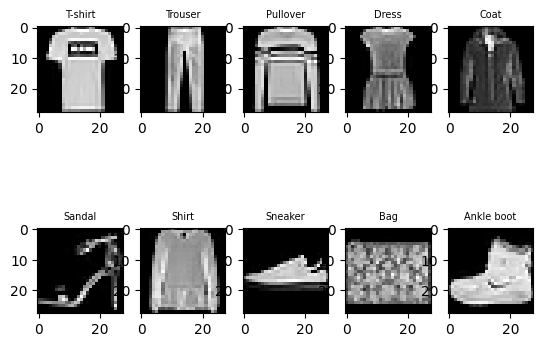

In [64]:
num_classes = len(np.unique(Y))
# for i in range(num_classes):
unique_classes = [X[np.where(Y == i)[0][0]] for i in range(num_classes)]
class_names = ["T-shirt", "Trouser", "Pullover", "Dress",
               "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
for i in range(1, num_classes+1):
    plt.subplot(2, 5, i)
    plt.imshow(unique_classes[i-1], cmap=plt.get_cmap('gray'))
    plt.title(class_names[i-1], fontdict={'fontsize': 7})
plt.show()


### Data Cleaning

In [65]:
num_features = np.shape(X)[1]*np.shape(X)[2]
X = X.reshape(np.shape(X)[0], 784)
X_test = X_test.reshape(np.shape(X_test)[0], 784)
X_train, Xv, Y_train, Yv = sklearn.model_selection.train_test_split(
    X, Y, test_size=0.2, random_state=4, shuffle=True)
print("Size of Training DataSet =", len(X_train))
print("Size of Validation DataSet =", len(Xv))
print("Size of Test DataSet =", len(X_test))
print("Number of classes =", num_classes)
print("Number of features =", num_features)
X_train = X_train.T
Xv = Xv.T


Size of Training DataSet = 48000
Size of Validation DataSet = 12000
Size of Test DataSet = 10000
Number of classes = 10
Number of features = 784


### Question 2

In [66]:
output_layer_nodes = num_classes
input_layer_nodes = num_features
num_hidden_layers = 10

In [67]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0,x)

def der_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def der_tanh(x):
    return 1-np.tanh(x)**2

def der_relu(x):
    return (x>0)*np.ones(x.shape)

### Hidden Layer


In [68]:
class hidden_layer:
    '''
        num_neurons : number of neurons in the layer
        dim_in_layer : in_layer dimensions
        dim_out_layer : outLayer dimensions
        W : Weights
        b : Biases
        grad_W : gradient of weights
        grad_B : gradient of biases
    '''
    def __init__(self,num_neurons,dim_in_layer,dim_out_layer = -1):
        self.weight_initializers = {"random": self.random_initialization, "Xavier": self.xavier_intialization}
        self.num_neurons = num_neurons
        # self.dimension = num_features
        self.dim_in_layer = dim_in_layer
        self.dim_out_layer = dim_out_layer
        
    def random_initialization(self, in_layer, out_layer):
        return np.random.randn(in_layer, out_layer)*0.01

    def xavier_intialization(self, in_layer, out_layer):
        return np.random.normal(0, np.sqrt(2 / (in_layer + out_layer)), size=(in_layer, out_layer))
    
    def initialize_layer(self,initializer):
        self.W = self.weight_initializers[initializer](in_layer = self.dim_in_layer,out_layer = self.num_neurons)
        self.b = np.zeros(shape=(self.num_neurons))
        self.a = np.zeros(shape= (self.num_neurons))
        self.h = np.zeros(shape=(self.dim_in_layer))
        
        self.grad_W = self.weight_initializers[initializer](in_layer = self.dim_in_layer,out_layer = self.num_neurons)
        self.grad_b = np.zeros(shape=(self.num_neurons))
        self.grad_a = np.zeros(shape= (self.num_neurons))
        self.grad_h = np.zeros(shape=(self.dim_in_layer))
        
        self.u_mgd_W = np.zeros(shape=(self.dim_in_layer,self.num_neurons))
        self.u_mgd_b = np.zeros(shape=(self.num_neurons))
        
        
        
        self.m_W = np.zeros(shape=(self.dim_in_layer,self.num_neurons))
        self.m_b = np.zeros(shape=(self.num_neurons))

### Feedforward Neural Network

In [71]:
class NeuralNet:
    '''
        weight_initializers : dictionary with random , xavier
        activation_funtions : dictionary with sigmoid, tanh, relu
        der_activation_functions : dictionary with derivatives of the above
        optimizer_funtions : dictionary with sgd, momentum, nestrov, rmsprop, adam, nadam}
        activation : string
        opitmizer : string
        learning_rate : int
        batch_size : int
        num_epochs : int
        num_features : dimension of X
        num_hidden_layers : int, number of hidden layers
        output_layer_dim : int
        hidden_layer_dims : np.array with num_neurons in all layer including input and output layer, dimension = num_hidden_layers 
        weight_Decay : 
        X_train : Training Data (n,d)
        Y_train : Training Data (n,)
        Xv : Validation Data (n,d)
        Yv : Validation Data (n,)
        hidden_layers : np.array of objects to class hidden_layer dimensions = num_hidden_layers
        output_layer : object to hidden_layer class
        beta : momentum
        beta1 : adam
        beta2 : adam
    '''
    def __init__(self,
                 num_features,
                 weight_initializer,
                 num_hidden_layers,
                 hidden_layer_dims,
                 optimizer,
                 learning_rate,
                 activation,
                 X_train,
                 Y_train,
                 Xv,
                 Yv,
                 weight_decay,
                 output_layer_dim,
                 batch_size,
                 num_epochs,
                 beta=0.9,
                 epsilon=1e-5,
                 beta1=0.9,
                 beta2=0.9):
        self.weight_initializer = weight_initializer
        self.activation_functions = {"sigmoid": sigmoid, "tanh": tanh, "ReLU": relu}
        self.der_activation_functions = {"sigmoid": der_sigmoid, "tanh": der_tanh, "ReLU": der_relu}
        self.optimizer_functions = {"sgd": self.sgd, "momentum": self.momentum,"nesterov": self.nestrov, "rmsprop": self.rmsprop, "adam": self.adam, "nadam": self.nadam}
        self.activation = self.activation_functions[activation]
        self.optimizer = self.optimizer_functions[optimizer]
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.num_hidden_layers = num_hidden_layers
        self.output_layer_dim = output_layer_dim
        self.hidden_layer_dims = hidden_layer_dims
        self.num_features = num_features
        self.weight_Decay = weight_decay
        self.X_train = X_train
        self.Y_train = Y_train
        self.Xv = Xv
        self.Yv = Yv
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        # return self
    
    def sgd(self,X,Y):
        self.ForwardPropagation(X)
        self.BackPropagation(self.output_layer.h,Y)
        L = self.hidden_layers
        for i in range(self.num_hidden_layers):
            L[i].W = L[i].W - self.learning_rate*L[i].grad_W
            L[i].b = L[i].b - self.learning_rate*L[i].grad_b
        self.output_layer.W = self.output_layer.W - self.learning_rate*self.output_layer.grad_W
        self.output_layer.b = self.output_layer.b - self.learning_rate*self.output_layer.grad_b
        
    def nestrov(self,X):
        pass
    
    def momentum(self,X):
        self.ForwardPropagation(X)
        self.BackPropagation(self.output_layer.h,Y)
        L = self.hidden_layers
        for i in range(self.num_hidden_layers):
            L[i].u_mgd_W = self.beta*L[i].u_mgd_W + L[i].grad_W
            L[i].u_mgd_b = self.beta*L[i].u_mgd_b + L[i].grad_b
            L[i].W = L[i].W - self.learning_rate*L[i].u_mgd_W
            L[i].b = L[i].b - self.learning_rate*L[i].u_mgd_b
        self.output_layer.u_mgd_W = self.beta*self.output_layer.u_mgd_W + self.output_layer.grad_W
        self.output_layer.u_mgd_b = self.beta*self.output_layer.u_mgd_b + self.output_layer.grad_b
        self.output_layer.W = self.output_layer.W - self.learning_rate*self.output_layer.u_mgd_W
        self.output_layer.b = self.output_layer.b - self.learning_rate*self.output_layer.u_mgd_b
        pass
    
    def rmsprop(self,X):
        self.ForwardPropagation(X)
        self.BackPropagation(self.output_layer.h,Y)
        L = self.hidden_layers
        beta = self.beta
        for i in range(self.num_hidden_layers):
            L[i].u_mgd_W = beta*L[i].u_mgd_W + (1-beta)*L[i].grad_W
            L[i].u_mgd_b = beta*L[i].u_mgd_b + (1-beta)*L[i].grad_b
            L[i].W = L[i].W - (self.learning_rate*L[i].grad_W/(np.sqrt(L[i].u_mgd_W+self.epsilon)))
            L[i].b = L[i].b - (self.learning_rate*L[i].grad_b/(np.sqrt(L[i].u_mgd_b+self.epsilon)))
        self.output_layer.u_mgd_W = beta*self.output_layer.u_mgd_W + (1-beta)*self.output_layer.grad_W
        self.output_layer.u_mgd_b = beta*self.output_layer.u_mgd_b + (1-beta)*self.output_layer.grad_b
        self.output_layer.W = self.output_layer.W - (self.learning_rate*self.output_layer.grad_W/(np.sqrt(self.output_layer.u_mgd_W+self.epsilon)))
        self.output_layer.b = self.output_layer.b - (self.learning_rate*self.output_layer.grad_b/(np.sqrt(self.output_layer.u_mgd_b+self.epsilon)))
        pass
    
    def adam(self,X):
        self.ForwardPropagation(X)
        self.BackPropagation(self.output_layer.h,Y)
        L = self.hidden_layers
        beta1 = self.beta1
        beta2 = self.beta2
        output = self.output_layer
        for i in range (self.num_hidden_layers):
            L[i].m_W = beta1*L[i].m_W + (1-beta1)*L[i].grad_W
            L[i].m_b = beta1*L[i].m_b + (1-beta1)*L[i].grad_b
            
            L[i].u_mgd_W = beta2*L[i].u_mgd_W + (1-beta2)*(L[i].grad_W**2)
            L[i].u_mgd_b = beta2*L[i].u_mgd_b + (1-beta2)*(L[i].grad_b**2)
            
            m_hat_W = L[i].m_W/(1 - np.power(beta1,i+1))
            m_hat_b = L[i].m_b/(1 - np.power(beta1,i+1))
            u_hat_W = L[i].u_mgd_W/(1 - np.power(beta2,i+1))
            u_hat_b = L[i].u_mgd_b/(1 - np.power(beta2,i+1))
            
            L[i].W = L[i].W - (self.learning_rate*m_hat_W/(np.sqrt(u_hat_W)+self.epsilon))
            L[i].b = L[i].b - (self.learning_rate*m_hat_b/(np.sqrt(u_hat_b)+self.epsilon))
        
        output.m_W = beta1*output.m_W + (1-beta1)*output.grad_W
        output.m_b = beta1*output.m_b + (1-beta1)*output.grad_b
        
        output.u_mgd_W = beta2*output.u_mgd_W + (1-beta2)*(output.grad_W**2)
        output.u_mgd_b = beta2*output.u_mgd_b + (1-beta2)*(output.grad_b**2)
        
        m_hat_W = output.m_W/(1 - np.power(beta1,i+1))
        m_hat_b = output.m_b/(1 - np.power(beta1,i+1))
        u_hat_W = output.u_mgd_W/(1 - np.power(beta2,i+1))
        u_hat_b = output.u_mgd_b/(1 - np.power(beta2,i+1))
        
        output.W = output.W - (self.learning_rate*m_hat_W/(np.sqrt(u_hat_W)+self.epsilon))
        output.b = output.b - (self.learning_rate*m_hat_b/(np.sqrt(u_hat_b)+self.epsilon))
            
        pass
    def nadam(self,X):
        self.ForwardPropagation(X)
        self.BackPropagation(self.output_layer.h,Y)
        L = self.hidden_layers
        beta1 = self.beta1
        beta2 = self.beta2
        output = self.output_layer
        for i in range (self.num_hidden_layers):
            L[i].m_W = beta1*L[i].m_W + (1-beta1)*L[i].grad_W
            L[i].m_b = beta1*L[i].m_b + (1-beta1)*L[i].grad_b
            
            L[i].u_mgd_W = beta2*L[i].u_mgd_W + (1-beta2)*(L[i].grad_W**2)
            L[i].u_mgd_b = beta2*L[i].u_mgd_b + (1-beta2)*(L[i].grad_b**2)
            
            m_hat_W = L[i].m_W/(1 - np.power(beta1,i+1))
            m_hat_b = L[i].m_b/(1 - np.power(beta1,i+1))
            u_hat_W = L[i].u_mgd_W/(1 - np.power(beta2,i+1))
            u_hat_b = L[i].u_mgd_b/(1 - np.power(beta2,i+1))
            
            L[i].W = L[i].W - (self.learning_rate/(np.sqrt(u_hat_W+self.epsilon)))*(beta1*m_hat_W+(1-beta1)*L[i].grad_W/(1-beta1**(i+1)))
            L[i].b = L[i].b - (self.learning_rate/(np.sqrt(u_hat_b+self.epsilon)))*(beta1*m_hat_b+(1-beta1)*L[i].grad_b/(1-beta1**(i+1)))
            # (eta/np.sqrt(v_w_hat+eps))* (beta1*m_w_hat+(1-beta1)*dw/(1-beta1**(i+1)))
        
        output.m_W = beta1*output.m_W + (1-beta1)*output.grad_W
        output.m_b = beta1*output.m_b + (1-beta1)*output.grad_b
        
        output.u_mgd_W = beta2*output.u_mgd_W + (1-beta2)*(output.grad_W**2)
        output.u_mgd_b = beta2*output.u_mgd_b + (1-beta2)*(output.grad_b**2)
        
        m_hat_W = output.m_W/(1 - np.power(beta1,i+1))
        m_hat_b = output.m_b/(1 - np.power(beta1,i+1))
        u_hat_W = output.u_mgd_W/(1 - np.power(beta2,i+1))
        u_hat_b = output.u_mgd_b/(1 - np.power(beta2,i+1))
        
        output.W = output.W - (self.learning_rate/(np.sqrt(u_hat_W+self.epsilon)))*(beta1*m_hat_W+(1-beta1)*output.grad_W/(1-beta1**(i+1)))
        output.b = output.b - (self.learning_rate/(np.sqrt(u_hat_b+self.epsilon)))*(beta1*m_hat_b+(1-beta1)*output.grad_b/(1-beta1**(i+1)))
        pass
    
    def Square_Error_Loss(self,Y_pred,Y_actual):
        return np.mean((Y_pred-Y_actual)**2)
    
    def Cross_Entropy_Loss(self,Y_pred,Y_actual):
        return -np.sum(Y_actual*np.log(Y_pred))/float(Y_pred.shape[0])
    
    def initialize_hidden_layers(self):
        L = []
        in_layer, out_layer = num_features,self.hidden_layer_dims[1]
        for i in range(self.num_hidden_layers):
            if  i == 0:
                in_layer = num_features
            else:
                in_layer = self.hidden_layer_dims[i-1]
                
            if i == self.num_hidden_layers-1:
                out_layer = self.output_layer_dim
            else:
                out_layer = self.hidden_layer_dims[i+1]
                
            L.append(hidden_layer(self.hidden_layer_dims[i],in_layer,out_layer))
            
        self.hidden_layers = np.array(L)
        self.output_layer = hidden_layer(self.output_layer_dim,self.hidden_layer_dims[self.num_hidden_layers-1],-1)
        
    def initialize_NeuralNet(self):
        for i in range(self.num_hidden_layers):
            self.hidden_layers[i].initialize_layer(self.weight_initializer)
        self.output_layer.initialize_layer(self.weight_initializer)
        pass
    
    def add_hidden(self,num_neurons):
        self.hidden_layer_dims.append(num_neurons)
        self.num_hidden_layers += 1
        self.initialize_hidden_layers()
        # self.initialize_NeuralNet()
        pass
    
    def ForwardPropagation(self,X):
        L = self.hidden_layers
        for i in range(self.num_hidden_layers):
            
            if i==0:
                # print(np.transpose(self.hidden_layers[i].W).shape,X.shape)
                L[i].a = L[i].b.reshape(L[i].b.shape[0],1) + np.matmul(np.transpose(L[i].W),X)
            else:
                # print(np.transpose(L[i].W).shape,L[i-1].h.shape)
                L[i].a = L[i].b.reshape(L[i].b.shape[0],1) + np.matmul(np.transpose(L[i].W),L[i-1].h)
            L[i].h = self.activation(L[i].a)
        # print(np.transpose(self.output_layer.W).shape,L[num_hidden_layers-1].h.shape)
        self.output_layer.a = self.output_layer.b.reshape(self.output_layer.b.shape[0],1) + np.matmul(np.transpose(self.output_layer.W),L[num_hidden_layers-1].h)
        self.output_layer.h = self.optimizer(self.output_layer.a)
        pass
    
    def BackPropagation(self,y_hat,y):
        L = self.hidden_layers
        N = self.num_hidden_layers
        self.output_layer.grad_a = y_hat - np.eye(num_classes)[y]
        # for the output layer
        self.output_layer.grad_W = np.matmul(self.output_layer.grad_a,np.transpose(L[N-1].h))
        self.output_layer.grab_b = self.output_layer.grad_a
        L[N-1].grad_h = np.matmlul(np.transpose(self.output_layer.W),self.output_layer.grad_a)
        L[N-1].grad_a = L[N-1].h * self.der_activation_functions[self.activation](L[N-1].a)
        
        for i in np.reverse(np.arange(N)):
            L[i].grad_W = np.matmul(L[i].grad_a,np.transpose(L[i-1].h))
            L[i].grab_b = L[i].grad_a
            L[i-1].grad_h = np.matmlul(np.transpose(L[i].W),L[i].grad_a)
            L[i-1].grad_a = L[i-1].h * self.der_activation_functions[self.activation](L[i-1].a)
        
        pass
        
    
    def fit_NeuralNet(self):
        self.initialize_hidden_layers()
        self.initialize_NeuralNet()
        # self.cost_per_epoch = np.zeros(self.num_epochs)
        for curr_epoch in range(self.num_epochs):
            for i in range(0,self.X_train.shape[1],self.batch_size):
                curr_batch = min(X_train.shape[1]-i,self.batch_size)
                self.optimizer_functions[self.optimizer](X_train[:,i:i+curr_batch],Y_train[:,i:i+curr_batch])
                
        pass
    
    def print_all(self):
        # print("weight_initializer = ",self.weight_initializer)
        # print("activation_functions = ",self.activation_functions)
        # print("optimizer_functions = ",self.optimizer_functions)
        # print("weight_initializers = ",self.weight_initializers)
        # print("activation = ",self.activation)
        # print("optimizer = ",self.optimizer)
        # print("learning_rate = ",self.learning_rate)
        # print("batch_size = ",self.batch_size)
        # print("num_epochs = ",self.num_epochs)
        # print("num_hidden_layers = ",self.num_hidden_layers)
        # print("output_layer_dim = ",self.output_layer_dim)
        # print("hidden_layer_dims = ",self.hidden_layer_dims)
        # print("num_features = ",self.num_features)
        # print("weight_Decay = ",self.weight_Decay)
        # print("X_train = ",self.X_train)
        # print("Y_train = ",self.Y_train)
        # print("Xv = ",self.Xv)
        # print("Yv = ",self.Yv)
        # print(self.output_layer.h)
        # for i in range(self.num_hidden_layers):
            
            # print(i)
            # print(i," ",self.hidden_layers[i].dim_in_layer,self.hidden_layers[i].num_neurons,self.hidden_layers[i].dim_out_layer,self.hidden_layers[i].W.shape,self.hidden_layers[i].b.shape)
            # print(self.hidden_layers[i].W)
            # print(self.hidden_layers[i].b.shape)
        # print("output-layer")
        # print(self.output_layer.W.shape)
        # print("o  ",self.output_layer.num_neurons,self.output_layer.dim_in_layer,self.output_layer.dim_out_layer)
        pass
    

In [12]:
# a = np.zeros(shape=(4,3)) + 3

# b = np.zeros(shape=(3,10)) + 4

# c = np.zeros(4).reshape(4,1) + 1
# # print(c)
# x = np.matmul(a,b) + c
# print(x)
# print(sigmoid(a))
# print(b)
# print(a*b)
l = []
# for i in range(0,50,10):
#     l.append(min(50-i,10))
# print(l)
ty =np.zeros((2,))
dy =np.zeros((2,))
print(ty.shape)
ty.reshape(1,2)
print(np.matmul(np.transpose(ty),dy))
# print(X_train.shape)

(2,)
0.0


In [70]:
hld = (np.arange(10)+np.ones(10)).astype(int)
# print(hld)
N = NeuralNet(X.shape[0],"random",10,hld,"sgd",0.1,"sigmoid",X_train,Y_train,Xv,Yv,0.3,4,3,1000)
N.initialize_hidden_layers()
N.initialize_NeuralNet()
N.ForwardPropagation(X_train[:,0:128])
N.BackPropagation()
# print(X_train.shape)
# for i in range(X_train.shape[0]):
#     N.ForwardPropagation(X_train[i])


N.print_all()

[[-1.73434906e-02]
 [ 3.17781553e-03]
 [ 1.10879888e-03]
 [ 4.08022448e-03]
 [ 1.13652840e-02]
 [ 3.44677810e-03]
 [-5.94813997e-03]
 [-1.67396087e-02]
 [ 1.19683831e-02]
 [ 1.72829473e-02]
 [-9.45813840e-03]
 [ 8.81086087e-03]
 [ 6.80724333e-03]
 [ 9.29567180e-03]
 [ 6.85370756e-03]
 [ 3.83514446e-03]
 [-1.85262620e-03]
 [-6.93655233e-04]
 [ 1.96924132e-03]
 [-1.82400724e-02]
 [ 3.58610609e-03]
 [ 1.68489374e-02]
 [-2.23252655e-03]
 [ 9.46585251e-04]
 [ 1.20801535e-02]
 [ 1.28575698e-02]
 [-1.01384756e-02]
 [ 2.25834803e-04]
 [ 1.95638095e-02]
 [-2.45389503e-02]
 [ 4.87572377e-03]
 [-8.18575855e-03]
 [-1.66741473e-03]
 [ 7.36104234e-03]
 [ 2.03498385e-03]
 [ 6.08371754e-03]
 [-2.40864041e-03]
 [ 1.14077190e-02]
 [-6.00030965e-03]
 [ 7.11130819e-03]
 [ 1.26514246e-03]
 [-1.78002613e-03]
 [ 3.29671063e-03]
 [ 9.01680939e-03]
 [ 2.60178013e-03]
 [-3.83696734e-03]
 [ 8.67252320e-03]
 [-4.82431988e-03]
 [ 1.23100681e-02]
 [-2.86988754e-03]
 [ 1.22880364e-02]
 [ 5.51676470e-04]
 [-1.6407273